In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pytensor
from pytensor import tensor as pt
from pytensor.tensor import random as ptr
from pytensor.scan import until
import pymc as pm
from matplotlib import pyplot as plt

In [3]:
seed = 42
def rng_ctor(seed_seq):
    return np.random.Generator(np.random.Philox(seed_seq))

rng = ptr.RandomStream(seed=seed, rng_ctor=rng_ctor)
rng.normal().eval()

array(-1.33507789)

In [4]:
def create_gaussian_particles(n_particles, mean=0, std=1):
    mean, std = pt.broadcast_arrays(mean, std)
    particles = rng.normal(loc=mean, scale=std, size=(n_particles, 3))
    particles = pt.set_subtensor(particles[:, 2], particles[:, 2] % (2 * np.pi))
    return particles

def predict(heading_change, velocity, particles, heading_noise, velocity_noise, dt):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = particles.shape[0]
    # update heading
    particles = pt.inc_subtensor(
        particles[:, 2], heading_change + rng.normal(size=N) * heading_noise
    )
    particles = pt.set_subtensor(particles[:, 2], particles[:, 2] % (2 * np.pi))

    # move in the (noisy) commanded direction
    dist = (velocity * dt) + (pm.HalfNormal.dist(size=N) * velocity_noise)
    particles = pt.inc_subtensor(particles[:, 0], pt.cos(particles[:, 2]) * dist)
    particles = pt.inc_subtensor(particles[:, 1], pt.sin(particles[:, 2]) * dist)
    return particles


def distances2(positions, landmarks):
    # positions.shape (n_particles, dim)
    # landmarks.shape (n_landmarks, dim)
    # out.shape (n_particles, n_landmarks)
    rel = positions[:, None, :] - landmarks[None, :, :]
    return (rel**2).sum(axis=-1)


def distances(positions, landmarks):
    return pt.sqrt(distances2(positions, landmarks))


def update(log_weights, particles, observed, sensor_noise, landmarks):
    dist_to_land = distances(particles[..., :2], landmarks)
    log_weights += pm.logprob.logp(
        pm.Normal.dist(dist_to_land, sensor_noise),
        observed
    ).sum(axis=-1)

    log_weights -= pt.logsumexp(log_weights)
    return log_weights

def estimate(particles, log_weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, :2]
    mean = pt.sum(pos * pt.exp(log_weights)[..., None], axis=-2) / pt.exp(log_weights).sum(axis=-1)
    var  = pt.sum((pos - mean)**2 * pt.exp(log_weights)[..., None], axis=-2) / pt.exp(log_weights).sum(axis=-1)
    return mean, pt.sqrt(var)


def neff(log_weights):
    return 1 / pt.sum(pt.exp(log_weights)**2)

def systematic_resample(particles, log_weights, n_particles):
    # make n_particles subdivisions, and choose positions with a
    # consistent random offset
    n_particles = n_particles.eval()
    positions = (rng.uniform() + pt.arange(n_particles)) / n_particles

    weights = pt.exp(log_weights)
    cumulative_sum = pt.cumsum(weights)
    indexes = pytensor.shared(np.zeros(n_particles, dtype='int'))
    i = pytensor.shared(np.array([0]))
    j = pytensor.shared(np.array([0]))
    
    def step(indexes, i, j, positions, cumulative_sum):
        ii = i[0]
        jj = j[0]
        increments = pt.switch(positions[ii] < cumulative_sum[jj], [1, 0], [0, 1])
        indexes_update = pt.set_subtensor(indexes[ii], jj)
        i_update = i + increments[0]
        j_update = j + increments[1]
        return [], {indexes: indexes_update, i: i_update, j: j_update}, until(ii >= n_particles)

    _, updates = pytensor.scan(
        step,
        non_sequences=[indexes, i, j, positions, cumulative_sum],
        n_steps=n_particles ** 2,
    )
    inds = updates[indexes]
    return particles[inds], pt.full(n_particles, -np.log(n_particles), dtype=log_weights.dtype)


def no_resample(particles, log_weights):
    return particles, log_weights


def particle_filter(
    observed_distances,
    landmarks,
    heading_changes,
    velocities,
    heading_noise,
    velocity_noise,
    sensor_noise,
    dt=1.,
    n_particles=1000,
    initial_particles=None,
):
    if initial_particles is None:
        initial_particles = create_gaussian_particles(n_particles=n_particles)

    initial_weights = -pt.ones(n_particles) * np.log(n_particles)
    

    def step(heading_change, velocity, observed_distance, particles, log_weights):
        particles = predict(
            particles=particles,
            heading_change=heading_change,
            velocity=velocity,
            heading_noise=heading_noise,
            velocity_noise=velocity_noise,
            dt=dt,
        )
        
        # incorporate measurements
        log_weights = update(
            particles=particles,
            log_weights=log_weights,
            observed=observed_distance,
            sensor_noise=sensor_noise,
            landmarks=landmarks,
        )
        
        # resample if too few effective particles
        particles, log_weights = pytensor.ifelse(
            neff(log_weights) < n_particles/2,
            systematic_resample(
                particles=particles,
                log_weights=log_weights,
                n_particles=pt.as_tensor_variable(n_particles),
            ),
            no_resample(particles, log_weights),
        )
        return particles, log_weights

    [particles, weights], _ = pytensor.scan(
        step,
        sequences=[
            pt.as_tensor_variable(heading_changes),
            pt.as_tensor_variable(velocities),
            pt.as_tensor_variable(observed_distances),
        ],
        outputs_info=[
            initial_particles,
            initial_weights,
        ],
    )
    return particles, weights

In [5]:
landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
heading_noise = 0.05
velocity_noise = 0.2
sensor_noise = 0.1
dt = 0.1

initial_position = np.array([0, 0, np.pi/4])
n_time = 30
intended_headings = np.zeros(n_time)
max_speed = 12
intended_velocities = np.concatenate(
    [
        np.linspace(0, max_speed, n_time // 3),
        np.full(n_time - 2 * (n_time // 3), max_speed),
        np.linspace(max_speed, 0, n_time // 3),
    ],
)

In [6]:
true_positions, _ = pytensor.scan(
    predict,
    outputs_info=[pt.as_tensor_variable([initial_position])],
    sequences=[
        pt.as_tensor_variable(intended_headings),
        pt.as_tensor_variable(intended_velocities),
    ],
    non_sequences=[heading_noise, velocity_noise, dt],
)
true_positions = true_positions[:, 0].eval()

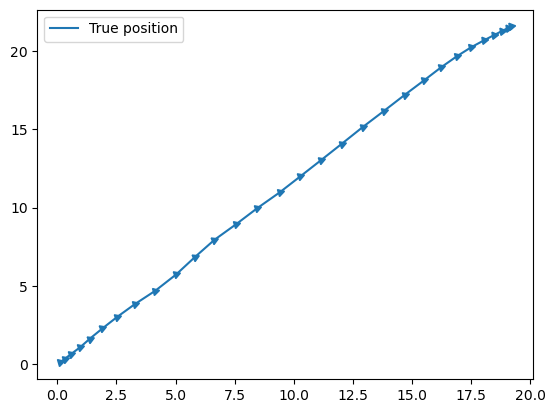

In [7]:
plt.plot(true_positions[:, 0], true_positions[:, 1], color="C0", label="True position")
for true_position in true_positions:
    plt.plot(
        true_position[0],
        true_position[1],
        marker=(3, 0, np.rad2deg(true_position[2])),
        color="C0",
    )
plt.legend();

In [8]:
observed_distances = distances(true_positions[..., :2], landmarks)

In [9]:
particles, log_weights = particle_filter(
    observed_distances=observed_distances,
    landmarks=landmarks,
    heading_changes=intended_headings,
    velocities=intended_velocities,
    heading_noise=heading_noise,
    velocity_noise=velocity_noise,
    sensor_noise=sensor_noise,
    dt=dt,
    n_particles=1000,
    initial_particles=None,
)

In [10]:
estimate_mean, estimate_std = estimate(particles, log_weights)

func = pytensor.function([], [estimate_mean, estimate_std, particles, log_weights])
mean, std, parts, lws = func()

/Users/lucianopaz/miniforge3/envs/pymc/lib/python3.11/site-packages/pytensor/tensor/rewriting/shape.py:156: UserWarning: Failed to infer_shape from Op Mul.
Input shapes: [(TensorConstant(TensorType(int64, shape=()), data=array(30)), TensorConstant(TensorType(int64, shape=()), data=array(2)), TensorConstant(TensorType(int64, shape=()), data=array(3))), (TensorConstant(TensorType(int64, shape=()), data=array(30)), TensorConstant(TensorType(int64, shape=()), data=array(1000)), TensorConstant(TensorType(int64, shape=()), data=array(1)))]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Could not broadcast dimensions. Incompatible shapes were [(TensorConstant(TensorType(int64, shape=()), data=array(30)), TensorConstant(TensorType(int64, shape=()), data=array(2)), TensorConstant(TensorType(int64, shape=()), data=array(3))), (TensorConstant(TensorType(int64, shape=()), data=array(30)), TensorConstant(TensorType(int64, shape=()), data=array(1000)), ScalarConsta

IndexError: index out of bounds
Apply node that caused the error: Subtensor{i}(*3-<Vector(float64, shape=(?,))>, ScalarFromTensor.0)
Toposort index: 6
Inputs types: [TensorType(float64, shape=(None,)), ScalarType(int64)]
Inputs shapes: [(1000,), ()]
Inputs strides: [(8,), ()]
Inputs values: ['not shown', 1000]
Outputs clients: [[ExpandDims{axis=0}(Subtensor{i}.0)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/Users/lucianopaz/miniforge3/envs/pymc/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/p0/81r8yvt526ldqjrrf14b4bd00000gn/T/ipykernel_29222/1489974652.py", line 1, in <module>
    particles, log_weights = particle_filter(
  File "/var/folders/p0/81r8yvt526ldqjrrf14b4bd00000gn/T/ipykernel_29222/1625854891.py", line 142, in particle_filter
    [particles, weights], _ = pytensor.scan(
  File "/Users/lucianopaz/miniforge3/envs/pymc/lib/python3.11/site-packages/pytensor/scan/basic.py", line 854, in scan
    raw_inner_outputs = fn(*args)
  File "/var/folders/p0/81r8yvt526ldqjrrf14b4bd00000gn/T/ipykernel_29222/1625854891.py", line 133, in step
    systematic_resample(
  File "/var/folders/p0/81r8yvt526ldqjrrf14b4bd00000gn/T/ipykernel_29222/1625854891.py", line 80, in systematic_resample
    _, updates = pytensor.scan(
  File "/Users/lucianopaz/miniforge3/envs/pymc/lib/python3.11/site-packages/pytensor/scan/basic.py", line 854, in scan
    raw_inner_outputs = fn(*args)
  File "/var/folders/p0/81r8yvt526ldqjrrf14b4bd00000gn/T/ipykernel_29222/1625854891.py", line 74, in step
    increments = pt.switch(positions[ii] < cumulative_sum[jj], [1, 0], [0, 1])

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.
Apply node that caused the error: Scan{scan_fn, while_loop=True, inplace=none}(16960, Subtensor{:stop}.0, Subtensor{:stop}.0, Subtensor{:stop}.0, Composite{(0.001 * (i0 + i1))}.0, CumOp{None, add}.0)
Toposort index: 35
Inputs types: [TensorType(int16, shape=()), TensorType(int64, shape=(1, None)), TensorType(int64, shape=(2, None)), TensorType(int64, shape=(1, None)), TensorType(float64, shape=(1000,)), TensorType(float64, shape=(None,))]
Inputs shapes: [(), (1, 1), (2, 1000), (1, 1), (1000,), (1000,)]
Inputs strides: [(), (8, 8), (8000, 8), (8, 8), (8,), (8,)]
Inputs values: [array(16960, dtype=int16), array([[0]]), 'not shown', array([[0]]), 'not shown', 'not shown']
Outputs clients: [[], [Subtensor{i}(Scan{scan_fn, while_loop=True, inplace=none}.1, -1)], []]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.
Apply node that caused the error: Scan{scan_fn, while_loop=False, inplace=all}(30, [[0. ... ]], [[[ 2.1862 ... 144801 ]]], SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, RNG(<Generator(Philox) at 0x12A2D1620>), RNG(<Generator(Philox) at 0x12A287920>), RNG(<Generator(PCG64) at 0x12A2D2420>), SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0)
Toposort index: 26
Inputs types: [TensorType(int64, shape=()), TensorType(float64, shape=(30, 1)), TensorType(float64, shape=(30, 1, 4)), TensorType(float64, shape=(30, 1000, 3)), TensorType(float64, shape=(30, 1000)), RandomGeneratorType, RandomGeneratorType, RandomGeneratorType, TensorType(int64, shape=(16961, None)), TensorType(int64, shape=(16961, None)), TensorType(int64, shape=(16961, None))]
Inputs shapes: [(), (30, 1), (30, 1, 4), (30, 1000, 3), (30, 1000), 'No shapes', 'No shapes', 'No shapes', (16961, 1), (16961, 1000), (16961, 1)]
Inputs strides: [(), (8, 8), (32, 32, 8), (24000, 24, 8), (8000, 8), 'No strides', 'No strides', 'No strides', (8, 8), (8000, 8), (8, 8)]
Inputs values: [array(30), 'not shown', 'not shown', 'not shown', 'not shown', Generator(Philox) at 0x12A2D1620, Generator(Philox) at 0x12A287920, Generator(PCG64) at 0x12A2D2420, 'not shown', 'not shown', 'not shown']
Outputs clients: [[Subtensor{:stop, :stop}(Scan{scan_fn, while_loop=False, inplace=all}.0, 30, 2), output[2](Scan{scan_fn, while_loop=False, inplace=all}.0)], [Exp(Scan{scan_fn, while_loop=False, inplace=all}.1), output[3](Scan{scan_fn, while_loop=False, inplace=all}.1)], [], []]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
plt.plot(true_positions[:, 0], true_positions[:, 1], color="k", label="True position")
plt.errorbar(mean[:, 0], mean[:, 1], std[:, 0], std[:, 1], color="C0", label="Estimate position")
plt.scatter(parts[:, 0], parts[:, 1], c=1, s=np.exp(lws) * 10, cmap="greens")
plt.legend();